In [32]:
import torch
from CNN.models import MlpRegBaseline
from CNN.datasets import Class_Seq_Dataset
from CNN.datasets import load_class_seq_data
import matplotlib.pylab as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import matthews_corrcoef

In [33]:
# useful functions:
def get_metrics(model_path):
    cp = torch.load(model_path, map_location=torch.device("cpu"))
    xval_data = cp["models_data"]
    a = cp["arguments"]
    print(a.cluster)

    csv_peptides, csv_ba_values, groups = load_class_seq_data("../../data/external/processed/BA_pMHCI.csv", a.threshold)
    dataset = Class_Seq_Dataset(csv_peptides, csv_ba_values, a.encoder, torch.device("cpu"))

    train_tpr = []
    train_losses = []
    train_tnr = []
    train_accuracies = []

    valid_tpr = []
    valid_losses = []
    valid_tnr = []
    valid_accuracies = []

    test_tpr = []
    test_losses = []
    test_tnr = []
    test_accuracies = []

    aucs = []
    mccs = []

    for data in xval_data:
        # load the model and data
        input_dimensions = (20*9, 40*9)[a.encoder=="mixed"]
        model = MlpRegBaseline(neurons_per_layer=a.neurons, input=input_dimensions, outputs=2) 
        model.load_state_dict(data["model"])
        model.eval()

        ### RETREIVE THE METRICS ###
        train_tpr.append(data["train_tpr"]);train_tnr.append(data["train_tnr"]);train_losses.append(data["train_losses"]);
        train_accuracies.append(data["train_accuracies"]);

        valid_tpr.append(data["validation_tpr"]);valid_tnr.append(data["validation_tnr"])
        valid_losses.append(data["validation_losses"]);valid_accuracies.append(data["validation_accuracies"]);

        test_tpr.append(data["test_tpr"]);test_tnr.append(data["test_tnr"]);test_losses.append(data["test_losses"]);
        test_accuracies.append(data["test_accuracies"]);

        ### MAKE THE PREDICTION ON THE TEST DATASET ###
        test_X = dataset.peptides[data["test_indices"]]
        test_label = dataset.labels[data["test_indices"]]

        with torch.no_grad():
            test_logits = model(test_X)
            test_prob = test_logits.max(1)[0] 
            test_pred = test_logits.max(1)[1]

        tpr, fpr, _ = roc_curve(test_label, test_prob) 
        aucs.append(auc(fpr, tpr))
        mccs.append(matthews_corrcoef(test_label, test_pred))

    return \
        aucs, mccs, \
        train_accuracies, valid_accuracies, test_accuracies,\
        train_tpr, valid_tpr, test_tpr,\
        train_tnr, valid_tnr, test_tnr,\
        train_losses, valid_losses, test_losses

In [34]:
models_path = "/home/daqop/Desktop/M2/Internship/python/trained_models/"
# models_path = "/home/daqop/mountpoint_snellius/3D-Vac/src/5_train_models/CNN/I/reg/seq/trained_models/"
# models_path = "/home/daqop/train_branch_3D_Vac/src/5_train_models/CNN/I/classification/seq/trained_models/"
model_names = {
    "shuffled": "mlp_classification_mixed_encoder_1000_neurons_50_epochs_shuffled_64_batch_size.pt",
    "clustered": "mlp_classification_mixed_encoder_1000_neurons_50_epochs_clustered_64_batch_size.pt",
    # "dtu_clustered": "mlp_classification_mixed_encoder_1000_neurons_200_epochs_clustered_dtu_64_batch_size.pt",
}
aucs, mccs, \
train_accuracies, valid_accuracies, test_accuracies, \
train_tpr, valid_tpr, test_tpr, \
train_tnr, valid_tnr, test_tnr, \
train_losses, valid_losses, test_losses = get_metrics(models_path + model_names["shuffled"])

aucs = torch.tensor(aucs)
mccs = torch.tensor(mccs)

train_accuracies = torch.permute(torch.tensor(train_accuracies), (1,0))
valid_accuracies = torch.permute(torch.tensor(valid_accuracies), (1,0))
test_accuracies = torch.permute(torch.tensor(test_accuracies), (1,0))

train_tpr = torch.permute(torch.tensor(train_tpr), (1,0))
valid_tpr = torch.permute(torch.tensor(valid_tpr), (1,0))
test_tpr = torch.permute(torch.tensor(test_tpr), (1,0))

train_tnr = torch.permute(torch.tensor(train_tnr), (1,0))
valid_tnr = torch.permute(torch.tensor(valid_tnr), (1,0))
test_tnr = torch.permute(torch.tensor(test_tnr).nan_to_num(), (1,0))

train_losses = torch.permute(torch.tensor(train_losses), (1,0))
valid_losses = torch.permute(torch.tensor(valid_losses), (1,0))
test_losses = torch.permute(torch.tensor(test_losses), (1,0))

False


Shuffled test accuracy mean:  tensor(0.8056)
Shuffled test accuracy standard deviation:  tensor(0.0601)
####
Shuffled validation accuracy mean:  tensor(0.7617)
Shuffled validation accuracy standard deviation:  tensor(0.0508)



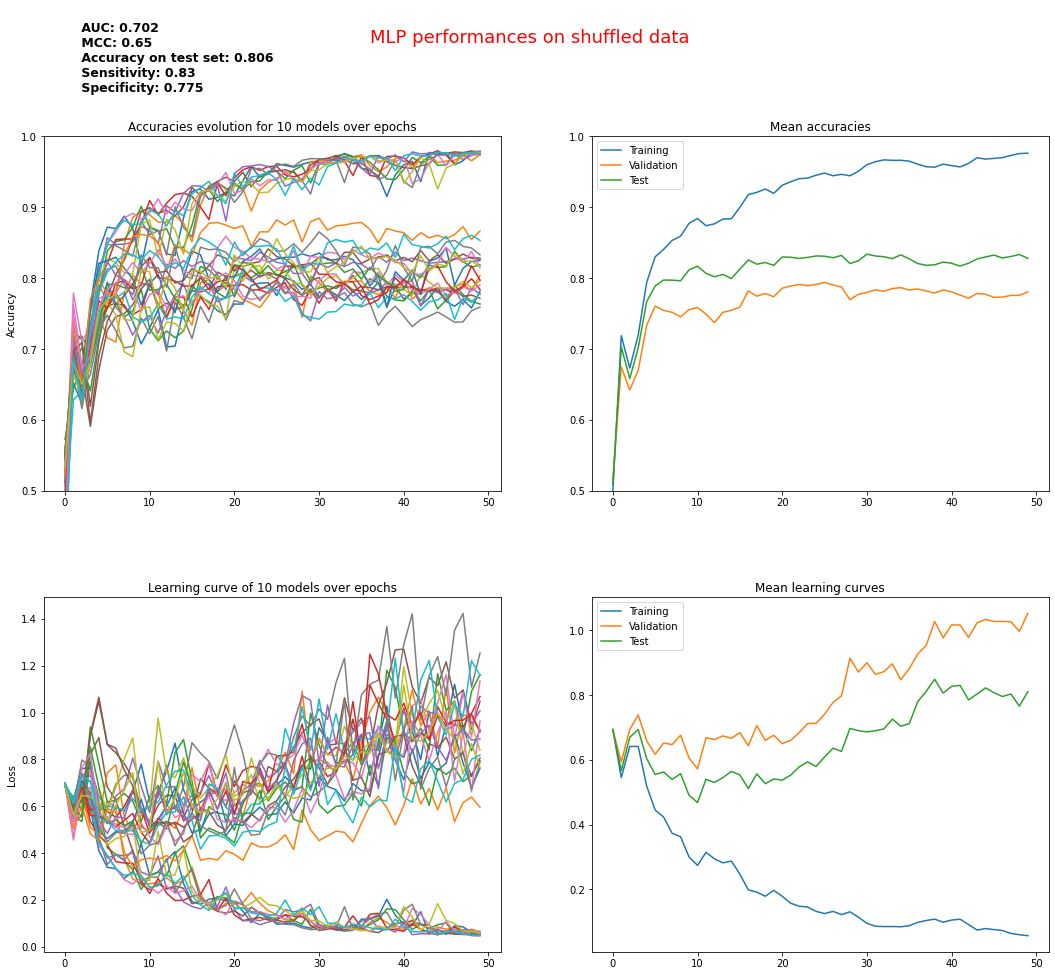

In [35]:
fig = plt.figure(figsize=(18,15))
((ax1, ax2), (ax3, ax4)) = fig.subplots(2, 2)
fig.suptitle(f"MLP performances on shuffled data", color="red", fontsize=18)
fig.text(
    0.15,1,
    f"\n AUC: {aucs.mean():.3} \n MCC: {mccs.mean():.3} \n \
Accuracy on test set: {test_accuracies.mean():.3} \n Sensitivity: {test_tpr.mean():.3} \n Specificity: {test_tnr.mean():.3}",
    horizontalalignment="left",
    verticalalignment="top",
    fontweight=700,
    fontsize=12.5
)

e = range(train_accuracies.shape[0])

ax1.plot(e, train_accuracies)
ax1.plot(e, valid_accuracies)
ax1.plot(e, test_accuracies)
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracies evolution for 10 models over epochs")
ax1.set_ylim(0.5,1)

ax2.plot(e, train_accuracies.mean(1))
ax2.plot(e, valid_accuracies.mean(1))
ax2.plot(e, test_accuracies.mean(1))
ax2.set_title("Mean accuracies")
ax2.legend(["Training", "Validation", "Test"])
ax2.set_ylim(0.5,1)

ax3.plot(e, train_losses)
ax3.plot(e, valid_losses)
ax3.plot(e, test_losses)
ax3.set_ylabel("Loss")
ax3.set_title("Learning curve of 10 models over epochs")

ax4.plot(e, train_losses.mean(1))
ax4.plot(e, valid_losses.mean(1))
ax4.plot(e, test_losses.mean(1))
ax4.set_title("Mean learning curves")
ax4.legend(["Training", "Validation", "Test"])

fig.subplots_adjust(
    wspace=.2,
    hspace=.3
)
fig.savefig("./shuffled_mlp_results.png", transparent=False, facecolor="white")
print("Shuffled test accuracy mean: ", test_accuracies.mean())
print("Shuffled test accuracy standard deviation: ", test_accuracies.std())
print("####")
print("Shuffled validation accuracy mean: ", valid_accuracies.mean())
print("Shuffled validation accuracy standard deviation: ", valid_accuracies.std())
print()